# Cycle3 NAO comparison plot

We compare the NAO teleconnection patterns between ERA5 and the nextGEMS simulations.
Data have been obtained with the CLI available in the `cli` folder of the diagnostic.

Setup files for the CLI used to produce these data are available in the repository, in the `cli` folder.

In [1]:
import xarray as xr

from teleconnections.plots import maps_plot

In [2]:
# Load the data
path = '/home/b/b382289/aqua_telec_output/data/NAO/'

models = ['IFS', 'IFS', 'ICON', 'ERA5']
exps = ['tco1279-orca025-cycle3', 'tco2559-ng5-cycle3', 'ngc3028', 'era5']

## Regression plots

We compare the regression plots obtained from ERA5 and nextGEMS simulations.
Notice that we don't compare here the index values, but they're available as they were produced by the CLI.

In [3]:
# Regressions
regs = []

regs.append(xr.open_dataarray(path + 'teleconnections_IFS_tco1279-orca025-cycle3_lra-r100-monthly_NAO_regression.nc'))
regs.append(xr.open_dataarray(path + 'teleconnections_IFS_tco2559-ng5-cycle3_lra-r100-monthly_NAO_regression.nc'))
regs.append(xr.open_dataarray(path + 'teleconnections_ICON_ngc3028_lra-r100-monthly_NAO_regression.nc'))
regs.append(xr.open_dataarray(path + 'teleconnections_ERA5_era5_monthly_NAO_regression.nc'))

# Custom titles so that different time periods can be shown

titles = ['IFS tco1279 (2020-01, 2024-12)',
          'IFS tco2559 (2020-01, 2024-12)',
          'ICON 3028 (2020-01, 2025-07)',
          'ERA5 (1940-01, 2022-12)']

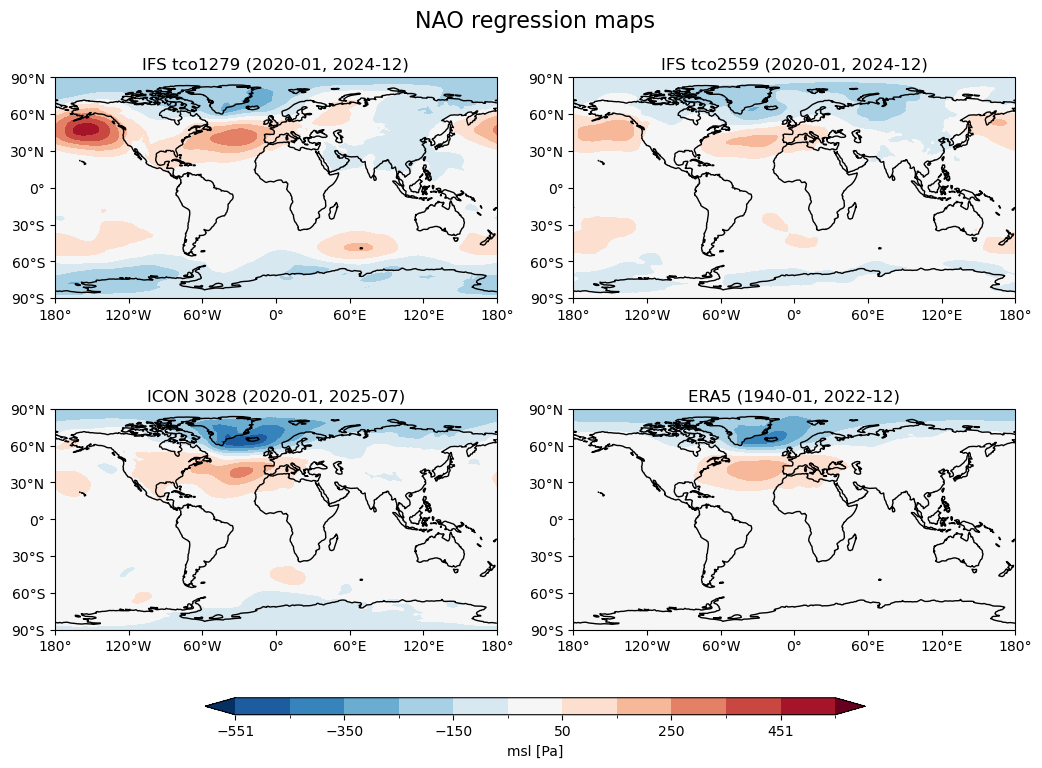

In [12]:
maps_plot(maps=regs, models=models, exps=exps, title='NAO regression maps', titles=titles, cbar_label='msl [Pa]', nlevels=12)

## Correlation plots

We compare the correlation plots obtained from ERA5 and nextGEMS simulations, same as the regression plots.

In [13]:
# Correlations
cors = []

cors.append(xr.open_dataarray(path + 'teleconnections_IFS_tco1279-orca025-cycle3_lra-r100-monthly_NAO_correlation.nc'))
cors.append(xr.open_dataarray(path + 'teleconnections_IFS_tco2559-ng5-cycle3_lra-r100-monthly_NAO_correlation.nc'))
cors.append(xr.open_dataarray(path + 'teleconnections_ICON_ngc3028_lra-r100-monthly_NAO_correlation.nc'))
cors.append(xr.open_dataarray(path + 'teleconnections_ERA5_era5_monthly_NAO_correlation.nc'))

titles = ['IFS tco1279 (2020-01, 2024-12)',
          'IFS tco2559 (2020-01, 2024-12)',
          'ICON 3028 (2020-01, 2025-07)',
          'ERA5 (1940-01, 2022-12)']

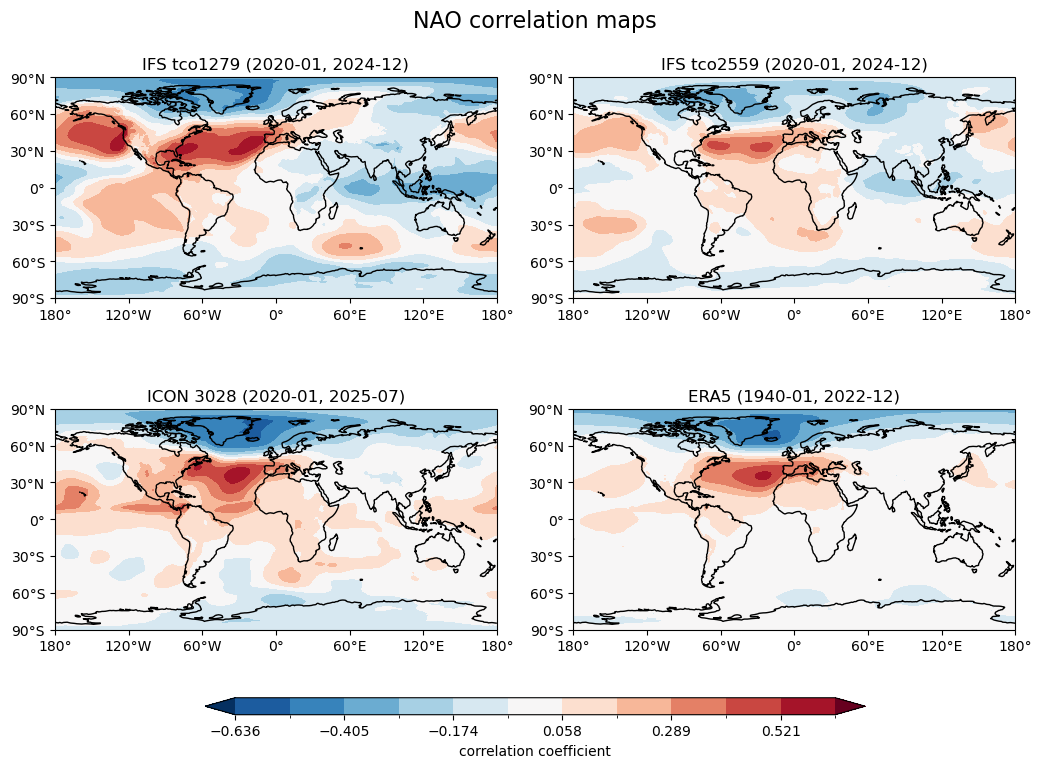

In [14]:
maps_plot(maps=cors, models=models, exps=exps, title='NAO correlation maps', titles=titles, cbar_label='correlation coefficient', nlevels=12)

## ERA5 comparison

Finally we plot the maps obtained from the subtraction of the ERA5 regression/correlation maps from the nextGEMS regression/correlation maps.

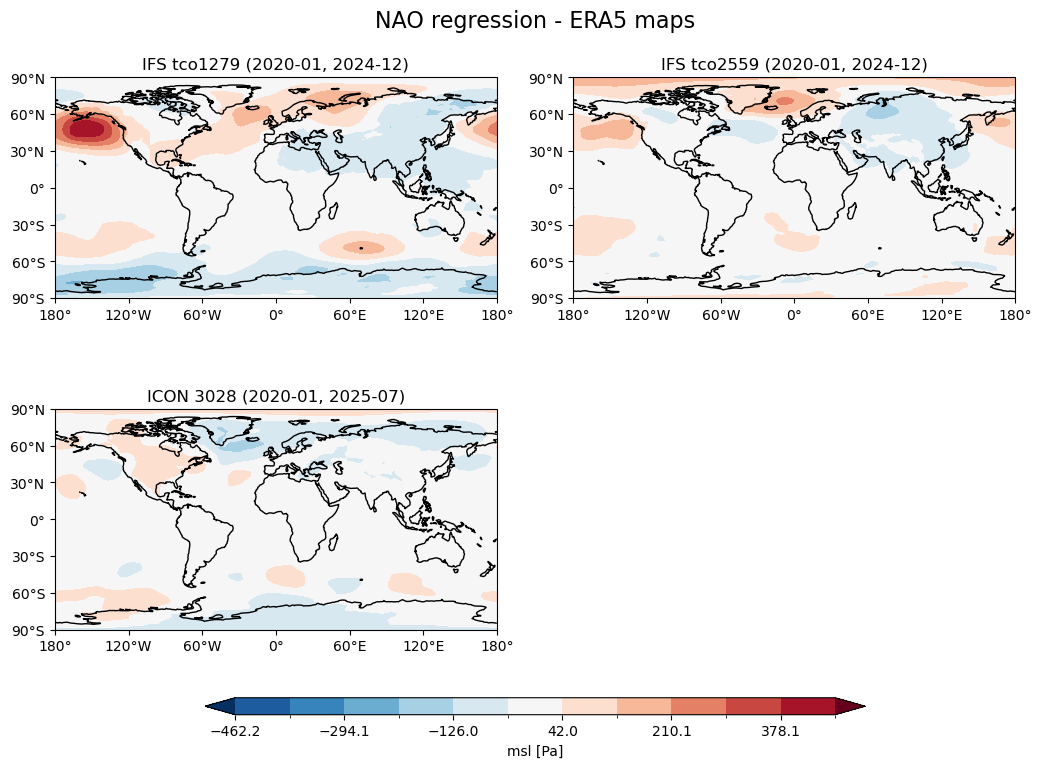

In [15]:
# Difference between experiments and ERA5 for regression
diffs_reg = []

for i in range(len(models)):
    diffs_reg.append(regs[i] - regs[-1])

titles = ['IFS tco1279 (2020-01, 2024-12)',
          'IFS tco2559 (2020-01, 2024-12)',
          'ICON 3028 (2020-01, 2025-07)',
          'ERA5 (1940-01, 2022-12)']

diffs_reg.pop(-1)

maps_plot(maps=diffs_reg, models=models, exps=exps, title='NAO regression - ERA5 maps', titles=titles, cbar_label='msl [Pa]', nlevels=12)

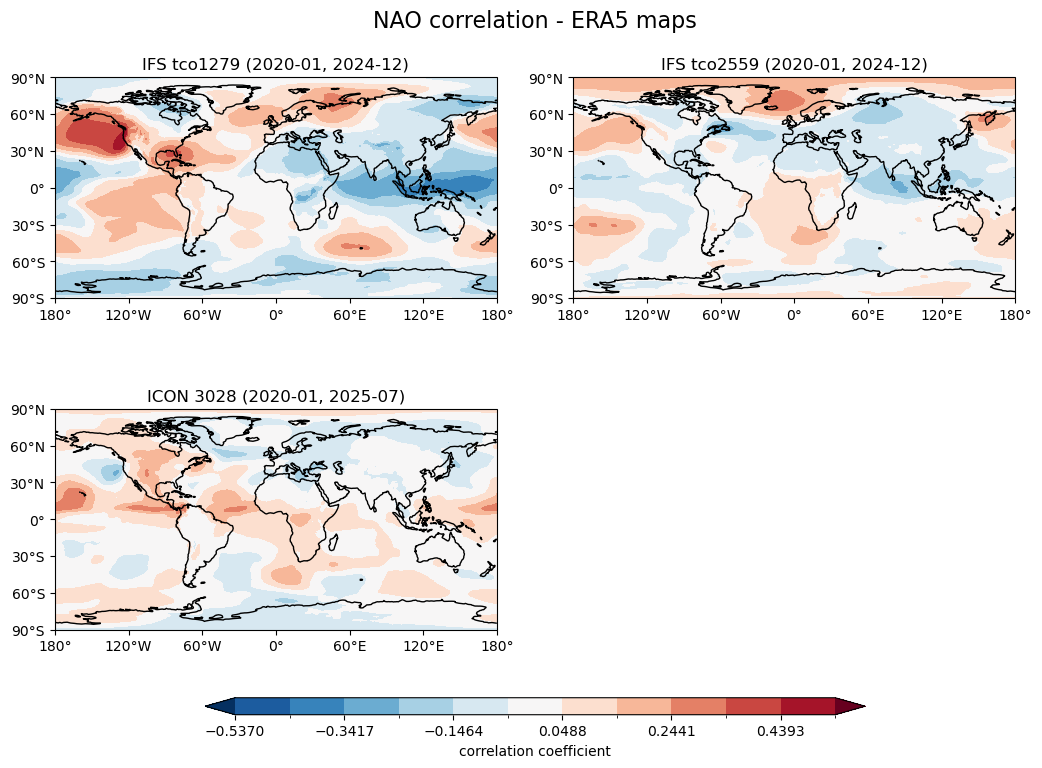

In [16]:
# Difference between experiments and ERA5 for correlation
diffs_cor = []

for i in range(len(models)):
    diffs_cor.append(cors[i] - cors[-1])

titles = ['IFS tco1279 (2020-01, 2024-12)',
          'IFS tco2559 (2020-01, 2024-12)',
          'ICON 3028 (2020-01, 2025-07)',
          'ERA5 (1940-01, 2022-12)']

diffs_cor.pop(-1)

maps_plot(maps=diffs_cor, models=models, exps=exps, title='NAO correlation - ERA5 maps', titles=titles, cbar_label='correlation coefficient', nlevels=12)